## Building a CNN model for predicting method of text input (handwritten or printed).

#### Importing necessary libraries

In [130]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Model,Input

##### Defining constants

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
data_dir = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\dataset"

#### Creating training and validation datasets. 
This is best done with use tensorflow utility function that allows immediate split of data into required proportion for training and validation.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 2 classes.
Using 45 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 2 classes.
Using 11 files for validation.


Naturally, there are two class names in the dataset

In [13]:
class_names = train_ds.class_names
print(class_names)

['Handwritten', 'Printed']


Let us take a look at few training images from both classes.

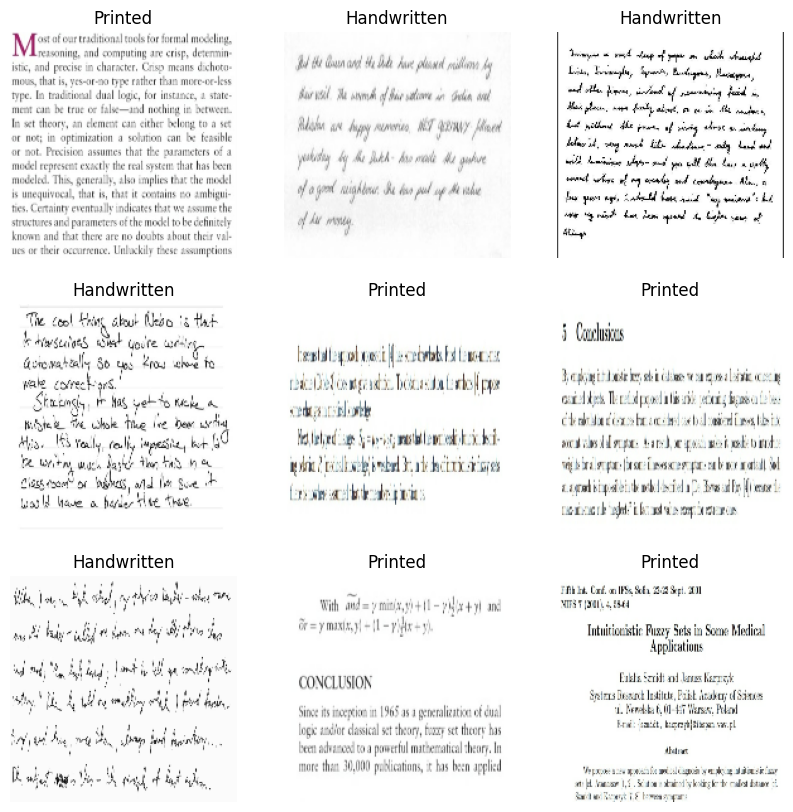

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Preprocessed images come in the form 4th rank tensor where first rank is represented by the pixel info at coordinates x, y ∈ {0-180}, and remaining ranks related to RGB 3 channel dimension of an image.

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Preparing dataset feeding optimization.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Due to lack 

In [49]:
data_augmentation = tf.keras.Sequential([
  #layers.RandomFlip("horizontal"),  # not in use
 # layers.RandomRotation(0.2),    # not in use
  tf.keras.layers.RandomZoom(    # random image zoom
    height_factor=0.25,
    width_factor=0.15,
    fill_mode='reflect',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)  # random image translation
])

#### Building the convolutional neural network.
We use re-scaling layer at the early beginning to have all pixel values in the range 0 to 1 for a better gradient descent.
It is followed by the data augmentation layer earlier defined. The feature extraction is performed by Conv2D layers with ReLu activation functions followed by Max pooling layers. Final layers are dense layers that provide classification weights to a probability model that will be defined later.

In [63]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
   
  tf.keras.layers.Dense(num_classes)
])

Compiling model with optimizer and loss function.

In [64]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.build((None, 180, 180, 3))

Let's review CNN model structure.

In [65]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 128)     3584      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 89, 89, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 89, 89, 512)       590336    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 44, 44, 512)       0         
 ng2D)                                               

It is wise to define early stopping and checkpoint callbacks that will be used during training.

In [66]:
model_file = os.path.join(os.getcwd(), 'best_weights')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 20, restore_best_weights = False)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

#### Training the model.
Feeding both training and validation datasets to run for a 200 epochs.

In [67]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=[early_stop, checkpoint]
)

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 1.7674 - accuracy: 0.4444
Epoch 1: val_loss improved from inf to 2.03225, saving model to C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights
INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


2/2 [==============================] - 11s 5s/step - loss: 1.7674 - accuracy: 0.4444 - val_loss: 2.0323 - val_accuracy: 0.6364
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 2.0894 - accuracy: 0.5111
Epoch 2: val_loss improved from 2.03225 to 0.77967, saving model to C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights
INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


2/2 [==============================] - 9s 5s/step - loss: 2.0894 - accuracy: 0.5111 - val_loss: 0.7797 - val_accuracy: 0.3636
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.4889
Epoch 3: val_loss improved from 0.77967 to 0.70832, saving model to C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights
INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


2/2 [==============================] - 9s 5s/step - loss: 0.7697 - accuracy: 0.4889 - val_loss: 0.7083 - val_accuracy: 0.3636
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.5111
Epoch 4: val_loss did not improve from 0.70832
2/2 [==============================] - 6s 2s/step - loss: 0.6994 - accuracy: 0.5111 - val_loss: 0.7842 - val_accuracy: 0.3636
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.5111
Epoch 5: val_loss improved from 0.70832 to 0.69326, saving model to C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights
INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


2/2 [==============================] - 9s 5s/step - loss: 0.7093 - accuracy: 0.5111 - val_loss: 0.6933 - val_accuracy: 0.3636
Epoch 6/200
2/2 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.4889
Epoch 6: val_loss did not improve from 0.69326
2/2 [==============================] - 6s 2s/step - loss: 0.6949 - accuracy: 0.4889 - val_loss: 0.7101 - val_accuracy: 0.3636
Epoch 7/200
2/2 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5111
Epoch 7: val_loss did not improve from 0.69326
2/2 [==============================] - 6s 2s/step - loss: 0.6926 - accuracy: 0.5111 - val_loss: 0.7256 - val_accuracy: 0.3636
Epoch 8/200
2/2 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5111
Epoch 8: val_loss did not improve from 0.69326
2/2 [==============================] - 6s 2s/step - loss: 0.6950 - accuracy: 0.5111 - val_loss: 0.7039 - val_accuracy: 0.3636
Epoch 9/200
2/2 [==============================] - ETA: 0s - loss: 0.6929 - 

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


2/2 [==============================] - 11s 6s/step - loss: 0.6664 - accuracy: 0.5111 - val_loss: 0.6255 - val_accuracy: 0.7273
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.6222
Epoch 23: val_loss did not improve from 0.62545
2/2 [==============================] - 7s 2s/step - loss: 0.6784 - accuracy: 0.6222 - val_loss: 0.8964 - val_accuracy: 0.3636
Epoch 24/200
2/2 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.5111
Epoch 24: val_loss did not improve from 0.62545
2/2 [==============================] - 7s 2s/step - loss: 0.6670 - accuracy: 0.5111 - val_loss: 0.8449 - val_accuracy: 0.3636
Epoch 25/200
2/2 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.6000
Epoch 25: val_loss did not improve from 0.62545
2/2 [==============================] - 6s 2s/step - loss: 0.6272 - accuracy: 0.6000 - val_loss: 1.4582 - val_accuracy: 0.3636
Epoch 26/200
2/2 [==============================] - ETA: 0s - loss: 0

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


2/2 [==============================] - 9s 5s/step - loss: 0.6817 - accuracy: 0.5333 - val_loss: 0.5371 - val_accuracy: 0.8182
Epoch 27/200
2/2 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5333
Epoch 27: val_loss did not improve from 0.53709
2/2 [==============================] - 6s 2s/step - loss: 0.6867 - accuracy: 0.5333 - val_loss: 0.6006 - val_accuracy: 0.8182
Epoch 28/200
2/2 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5333
Epoch 28: val_loss did not improve from 0.53709
2/2 [==============================] - 7s 2s/step - loss: 0.6883 - accuracy: 0.5333 - val_loss: 0.7144 - val_accuracy: 0.3636
Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.5111
Epoch 29: val_loss did not improve from 0.53709
2/2 [==============================] - 6s 2s/step - loss: 0.7012 - accuracy: 0.5111 - val_loss: 0.6006 - val_accuracy: 0.3636
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


2/2 [==============================] - 10s 6s/step - loss: 0.7723 - accuracy: 0.4889 - val_loss: 0.5330 - val_accuracy: 0.8182
Epoch 34/200
2/2 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.5111
Epoch 34: val_loss did not improve from 0.53302
2/2 [==============================] - 7s 2s/step - loss: 0.7184 - accuracy: 0.5111 - val_loss: 0.6396 - val_accuracy: 0.7273
Epoch 35/200
2/2 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.4889
Epoch 35: val_loss did not improve from 0.53302
2/2 [==============================] - 7s 2s/step - loss: 0.7067 - accuracy: 0.4889 - val_loss: 0.6725 - val_accuracy: 0.7273
Epoch 36/200
2/2 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5111
Epoch 36: val_loss did not improve from 0.53302
2/2 [==============================] - 7s 2s/step - loss: 0.6923 - accuracy: 0.5111 - val_loss: 0.7242 - val_accuracy: 0.3636
Epoch 37/200
2/2 [==============================] - ETA: 0s - loss: 0

Now, we restore the best weights that were obtained during training process.

In [68]:
model.load_weights(model_file)

Saving the model.

In [69]:
model.save(os.getcwd())

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\assets


Defining function for plotting training progress log.

In [70]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.plot(history.epoch, history.history['loss'],
               color = colors[n], label = 'Training' + label)
  plt.plot(history.epoch, history.history['val_loss'],
               color = colors[n], label = 'Validation' + label,
               linestyle = "--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [74]:
plt.rcParams['figure.figsize'] = (12, 5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

As can be seen from below figure, in contrast to training loss, validation loss have had few extremums that allowed to obtain relatively good training weights at respective checkpoints.

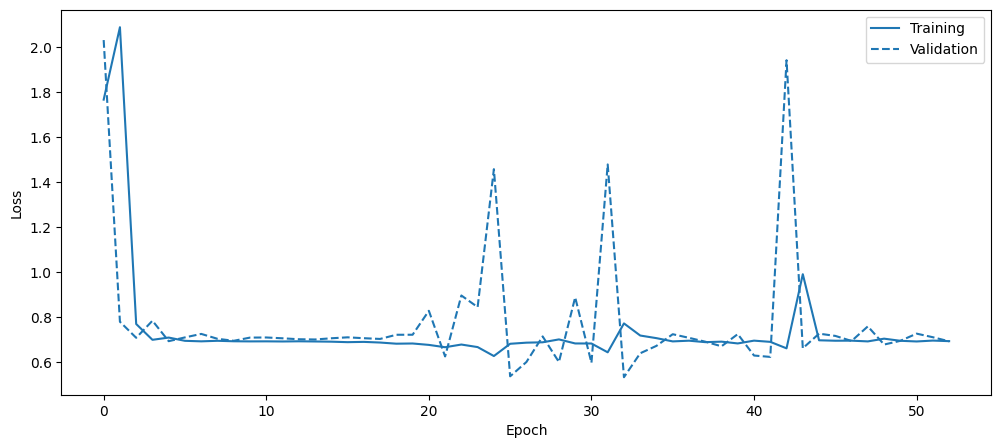

In [75]:
plot_loss(history, '', 0)

#### Model evaluation.

Defining our classification model with softmax activation function, as suggested by the true labels type.

In [76]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

Preparing images to be fed to the classification model.

In [77]:
def get_all_filePaths(folderPath):
    result = []
    for dirpath, dirnames, filenames in os.walk(folderPath):
        result.extend([os.path.join(dirpath, filename) for filename in filenames])
    return result

In [103]:
test_images = []
img_arr = []
for img_path in get_all_filePaths(data_dir):
    img = PIL.Image.open(img_path).convert('RGB')
    img_arr.append(img)
    image = tf.convert_to_tensor(img)
    input_tensor = tf.image.resize(image, [img_height, img_width])
    # add another dimension at the front to get NHWC shape
    test_images.append(tf.expand_dims(input_tensor, axis=0))
len(test_images)

Running predictions

In [91]:
predicted = []
for img in test_images:
    predictions = probability_model.predict(img)
    predicted.append(predictions)

1/1 [==============================] - 0s 56ms/step


In [119]:
test_labels = []
test_labels.append(class_names.index('Handwritten'))
test_labels.append(class_names.index('Printed'))

Defining function for plotting images

In [96]:
def plot_image(predictions_array, true_label, img):
  true_label, img = true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

Let us plot few random images with their predicted labels along.

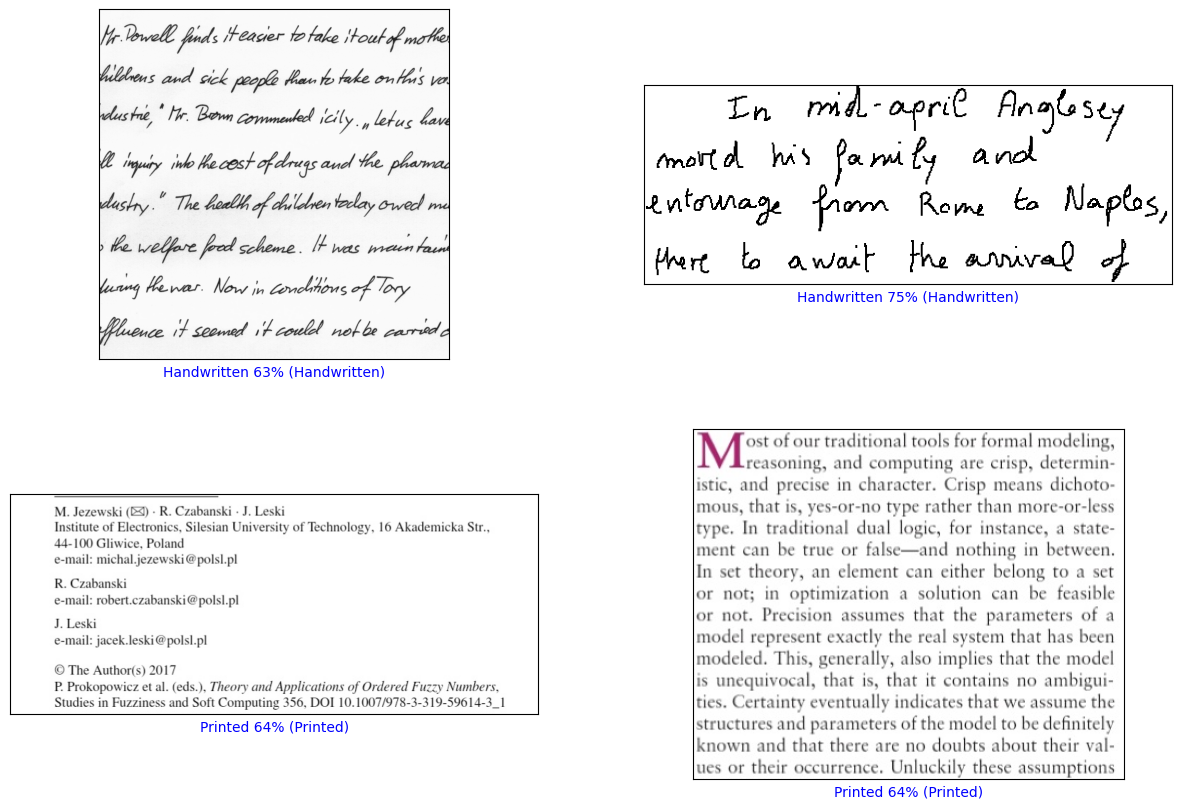

In [124]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_image(predicted[10], test_labels[0], img_arr[10])
plt.subplot(2,2,2)
plot_image(predicted[20], test_labels[0], img_arr[20])
plt.subplot(2,2,3)
plot_image(predicted[30], test_labels[1], img_arr[30])
plt.subplot(2,2,4)
plot_image(predicted[40], test_labels[1], img_arr[40])

plt.show()

Since dataset is very small, we shall evaluate the model over both combined know and unknown to model data.

In [126]:
full_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 2 classes.


As can be seen from obtained result, prediction accuracy is above 70%.

In [138]:
baseline_results = model.evaluate(full_ds,
                                  batch_size=batch_size, verbose=0)
metric_name = []
for i, _ in enumerate(model.metrics):
    metric_name.append(model.metrics[i].name)
metric_results = pd.DataFrame(baseline_results).transpose().round(3)
metric_results.columns = metric_name
metric_results.rename(index={0: 'value'})

,loss,accuracy
value,0.559,0.732


#### Conclusions.
Feature extraction method used in CNN is quite efficient and can provide satisfactory results even with limited training data.
Data augmentation is another useful technique that allows to enrich training dataset with some features using its own content. 